In [89]:
#Mounting Google Colab to Google Drive:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [91]:
root_path = '/content/drive/MyDrive/CS583/'

In [92]:
class RandomActivation(tf.keras.layers.Layer):
    def __init__(self):
        super(RandomActivation, self).__init__()

    def call(self, inputs):
        # Introduce randomness with uniform distribution
        random_values = tf.random.uniform(tf.shape(inputs), minval=-1.0, maxval=1.0)
        return random_values

loaded_model = tf.keras.models.load_model(root_path+'models/model_20ep_55acc.h5', custom_objects={'RandomActivation': RandomActivation})
#/content/drive/MyDrive/CS583/models/model_20ep_55acc.h5

In [93]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 batch_normalization_21 (Ba  (None, 253, 253, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 batch_normalization_22 (Ba  (None, 251, 251, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 batch_normalization_23 (Ba  (None, 126, 126, 32)     

In [94]:
image_df = pd.read_csv(root_path+'image_df_new.csv')
image_df['Prediction'] = image_df['Prediction'].astype(str)
image_df

,Company,Image_Path,Start_Date,End_Date,Prediction
0,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-02,2013-01-30,0
1,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-16,2013-02-13,1
2,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-01-31,2013-02-28,1
3,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-02-14,2013-03-14,0
4,MSFT,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2013-03-01,2013-03-28,0
...,...,...,...,...,...
2485,JNJ,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2022-09-12,2022-10-07,1
2486,JNJ,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2022-09-26,2022-10-21,1
2487,JNJ,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2022-10-10,2022-11-04,1
2488,JNJ,/content/drive/MyDrive/CS583/GAF_img_data/MSFT...,2022-10-24,2022-11-18,0


In [95]:
image_df['Prediction'].to_list().count('0'), image_df['Prediction'].to_list().count('1')

(1207, 1283)

In [30]:
def plot_stock_prices(company_name, start_date, end_date):
    # Load CSV file for the specified company
    file_name = root_path+'ten_companies_cleaned_csvs/'+company_name+".csv"
    try:
        data = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
        return

    # Convert 'date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Filter data between start_date and end_date
    mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
    filtered_data = data.loc[mask]

    if filtered_data.empty:
        print(f"No data available for {company_name} between {start_date} and {end_date}.")
        return

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
    plt.title(f"Stock Prices for {company_name} between {start_date} and {end_date}")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Company Name:  MSFT
Start Date:  2016-12-20
End Date:  2017-01-19



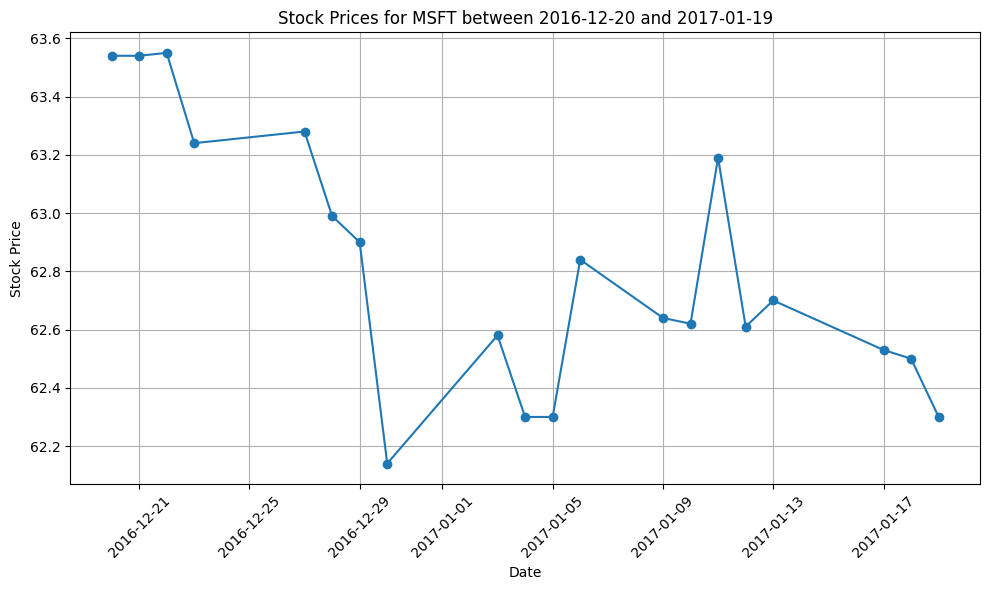

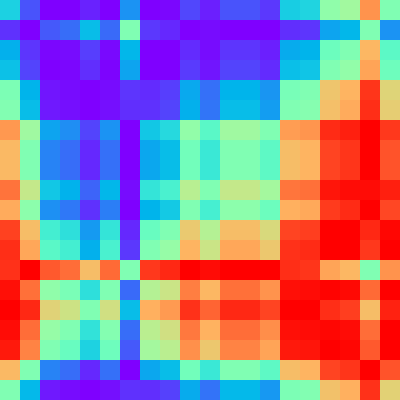

Prediction:  1


In [96]:
i=100
image_df.iloc[i]
print("Company Name: ", image_df.iloc[i]['Company'])
print("Start Date: ", image_df.iloc[i]['Start_Date'])
print("End Date: ", image_df.iloc[i]['End_Date'])
print()

plot_stock_prices(image_df.iloc[i]['Company'], image_df.iloc[i]['Start_Date'], image_df.iloc[i]['End_Date'])
print()
image = cv2.imread(image_df['Image_Path'][i])
image = cv2.resize(image, (400,400))
cv2_imshow(image)

print("Prediction: ",image_df.iloc[i]['Prediction'])

(800, 800, 3)
(255, 255, 3)


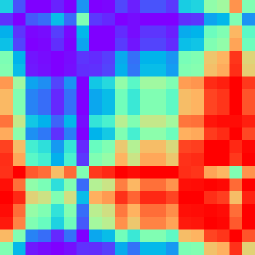

In [97]:
image = cv2.imread(image_df['Image_Path'][i])
print(image.shape)
image = cv2.resize(image, (255,255))
print(image.shape)
cv2_imshow(image)

In [99]:
image = image.reshape([1,255,255,3])
image.shape

(1, 255, 255, 3)

In [100]:
predictions = loaded_model.predict(image)
binary_predictions = (predictions > 0.5).astype(int)
print("Prediction: ", binary_predictions)

1/1 [==============================] - 1s 529ms/step
Prediction:  [[1]]
